In [1]:
from convokit import Corpus, download
import pandas as pd

# Download and load the corpus
corpus = Corpus(filename=download("movie-corpus"))

# Extract conversations into a list
conversations = list(corpus.iter_conversations())

# Example: print a sample conversation
for utt_id in conversations[0].get_utterance_ids():
    print(corpus.get_utterance(utt_id).text)

They do not!
They do to!


In [2]:
import re

# Function to clean text by removing brackets, punctuation, and extra spaces
def clean_text(text):
    text = re.sub(r'\[.*?\]', '', text)  # remove content inside brackets
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-alphabet characters
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text.lower()  # convert to lowercase

# Clean the text for all utterances
for convo in conversations:
    for utt_id in convo.get_utterance_ids():
        utt = corpus.get_utterance(utt_id)
        utt.text = clean_text(utt.text)

          text                  genre
0  they do not  ['comedy', 'romance']
1   they do to  ['comedy', 'romance']
2    i hope so  ['comedy', 'romance']
3     she okay  ['comedy', 'romance']
4      lets go  ['comedy', 'romance']


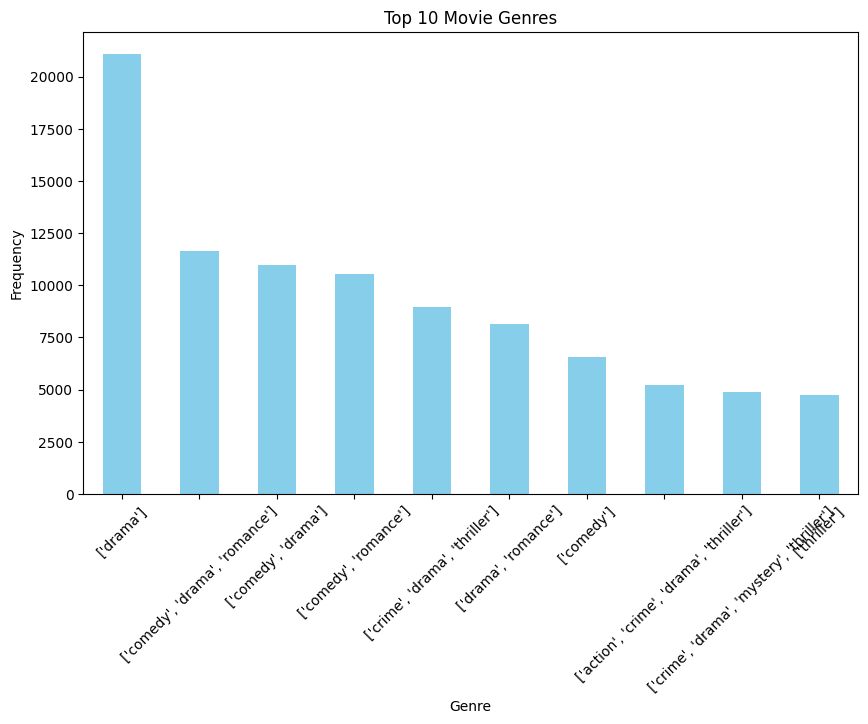

In [4]:
import matplotlib.pyplot as plt

# Initialize an empty list to store the conversation data
conversation_data = []

# Loop through your processed conversations
for convo in conversations:
    for utt_id in convo.get_utterance_ids():
        utt = corpus.get_utterance(utt_id)
        processed_text = utt.text  # This is the cleaned and processed text
        
        # Try both 'genre' and 'genres' keys
        genre = convo.meta.get('genre', convo.meta.get('genres', 'unknown'))
        
        # Append to the conversation_data list
        conversation_data.append({'text': processed_text, 'genre': genre})

# Convert the conversation data to a DataFrame
df = pd.DataFrame(conversation_data)

# Display the first few rows of the DataFrame to check
print(df.head())

# Count the frequency of each genre
genre_counts = df['genre'].value_counts()

# Select the top 10 most frequent genres
top_10_genres = genre_counts.nlargest(10)

# Plot the top 10 genres
plt.figure(figsize=(10,6))
top_10_genres.plot(kind='bar', color='skyblue')
plt.title("Top 10 Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [6]:
# Create a dictionary to store dataframes for each genre
genre_dfs = {}

# For each genre in your top 10 or full genre list
unique_genres = df['genre'].explode().unique()  # Get a list of unique genres

for genre in unique_genres:
    # Filter the dataframe for this specific genre
    genre_dfs[genre] = df[df['genre'].apply(lambda x: genre in x)]

In [7]:
import torch
from torch.utils.data import Dataset

class MovieDialoguesDataset(Dataset):
    def __init__(self, dataframe):
        self.input_ids = dataframe['input_ids'].tolist()
        self.labels = dataframe['response_ids'].tolist()

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [8]:
from transformers import GPT2Tokenizer

# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set the padding token to EOS

# Define a function to tokenize the input and response texts
def tokenize_text(text, max_length=128):
    return tokenizer.encode(text, truncation=True, padding='max_length', max_length=max_length)

# Tokenize each genre DataFrame
for genre, genre_df in genre_dfs.items():
    genre_df['input_ids'] = genre_df['text'].apply(lambda x: tokenize_text(x))
    genre_df['response_ids'] = genre_df['text'].apply(lambda x: tokenize_text(x))  # Use response as necessary

    # Ensure sequences are of consistent length, filter out any that don't match max_length
    genre_df = genre_df[genre_df['input_ids'].apply(len) == 128]
    genre_df = genre_df[genre_df['response_ids'].apply(len) == 128]

    # Save processed data in genre_dfs for later
    genre_dfs[genre] = genre_df

/var/folders/8j/8zxjcfw125g4mfl6xvm5bl080000gn/T/ipykernel_87120/1140815315.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['input_ids'] = genre_df['text'].apply(lambda x: tokenize_text(x))
/var/folders/8j/8zxjcfw125g4mfl6xvm5bl080000gn/T/ipykernel_87120/1140815315.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['response_ids'] = genre_df['text'].apply(lambda x: tokenize_text(x))  # Use response as necessary
/var/folders/8j/8zxjcfw125g4mfl6xvm5bl080000gn/T/ipykernel_87120/1140815

In [9]:
genre_datasets = {}

for genre, genre_df in genre_dfs.items():
    genre_datasets[genre] = MovieDialoguesDataset(genre_df)

In [11]:
print(genre_datasets.keys())

dict_keys(["['comedy', 'romance']", "['adventure', 'biography', 'drama', 'history']", "['action', 'crime', 'drama', 'thriller']", "['adventure', 'mystery', 'sci-fi']", "['action', 'comedy', 'crime', 'drama', 'thriller']", "['action', 'adventure', 'romance', 'sci-fi', 'thriller']", "['crime', 'mystery', 'thriller']", "['fantasy', 'horror', 'thriller']", "['sci-fi', 'thriller']", "['drama', 'mystery', 'thriller']", "['action', 'drama', 'thriller']", "['comedy', 'romance', 'sci-fi']", "['crime', 'drama', 'sci-fi', 'thriller']", "['action', 'sci-fi', 'thriller']", "['biography', 'drama', 'music']", "['horror', 'romance']", "['drama']", "['action', 'western']", "['drama', 'thriller']", "['action', 'adventure', 'comedy', 'crime']", "['action', 'adventure', 'thriller']", "['action', 'crime', 'drama', 'mystery', 'thriller']", "['crime', 'drama']", "['comedy', 'drama', 'music']", "['drama', 'romance', 'war']", "['crime', 'drama', 'mystery', 'thriller']", "['adventure', 'drama', 'fantasy']", "['

In [12]:
# This code parses the genre as a string and converts it back into a list of genres.
# We will create a proper dictionary with parsed genre lists.
corrected_genre_datasets = {}

for genre_str, dataset in genre_datasets.items():
    try:
        # Remove any extra quotes and spaces, then convert the string back to a list
        genre_list = eval(genre_str)
        corrected_genre_datasets[genre_list[0]] = dataset  # Assuming the first genre is the main one to focus on.
    except Exception as e:
        print(f"Error parsing genre: {genre_str}, Error: {str(e)}")

# Now, use corrected_genre_datasets for training
print(corrected_genre_datasets.keys())  # Check that the keys now look like correct genres

Error parsing genre: [], Error: list index out of range
dict_keys(['comedy', 'adventure', 'action', 'crime', 'fantasy', 'sci-fi', 'drama', 'biography', 'horror', 'animation', 'thriller', 'mystery', 'short', 'family', 'romance', 'documentary', 'film-noir'])


In [13]:
from transformers import GPT2LMHeadModel, Trainer, TrainingArguments

def train_model_for_genre(genre, dataset):
    # Load the GPT-2 model
    model = GPT2LMHeadModel.from_pretrained('gpt2')

    # Define training arguments specific for this genre
    training_args = TrainingArguments(
        output_dir=f'/tmp/{genre}_model_results',  # Directory for saving model
        num_train_epochs=3,  # Adjust as needed
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'/tmp/logs_{genre}',  # Log directory for this genre
        logging_steps=10,
    )

    # Create the Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
    )

    # Train the model
    trainer.train()

    # Save the trained model
    model.save_pretrained(f'/tmp/{genre}_model')

In [14]:
# Manually control which genres to train
genres_to_train = ["drama", "comedy", "romance"]  # Feel free to adjust

for genre in genres_to_train:
    if genre in corrected_genre_datasets:  # Ensure we have data for this genre
        print(f"Training model for {genre}...")
        train_model_for_genre(genre, corrected_genre_datasets[genre])
        print(f"Finished training for {genre}!")
    else:
        print(f"Skipping {genre} as no dataset was found.")

Training model for drama...


  1%|          | 10/852 [00:10<11:08,  1.26it/s]

{'loss': 11.9709, 'grad_norm': 196.16685485839844, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.04}


  2%|▏         | 20/852 [00:17<11:05,  1.25it/s]

{'loss': 10.4892, 'grad_norm': 210.00729370117188, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.07}


  4%|▎         | 30/852 [00:26<11:09,  1.23it/s]

{'loss': 5.9351, 'grad_norm': 102.77351379394531, 'learning_rate': 3e-06, 'epoch': 0.11}


  5%|▍         | 40/852 [00:34<10:45,  1.26it/s]

{'loss': 2.1076, 'grad_norm': 36.28684997558594, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.14}


  6%|▌         | 50/852 [00:42<10:39,  1.25it/s]

{'loss': 0.834, 'grad_norm': 9.63382339477539, 'learning_rate': 5e-06, 'epoch': 0.18}


  7%|▋         | 60/852 [00:50<11:19,  1.17it/s]

{'loss': 0.6302, 'grad_norm': 8.121956825256348, 'learning_rate': 6e-06, 'epoch': 0.21}


  8%|▊         | 70/852 [00:58<10:21,  1.26it/s]

{'loss': 0.5943, 'grad_norm': 5.362802982330322, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.25}


  9%|▉         | 80/852 [01:06<10:16,  1.25it/s]

{'loss': 0.6649, 'grad_norm': 5.190223217010498, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.28}


 11%|█         | 90/852 [01:14<10:11,  1.25it/s]

{'loss': 0.4552, 'grad_norm': 2.3436312675476074, 'learning_rate': 9e-06, 'epoch': 0.32}


 12%|█▏        | 100/852 [01:22<09:59,  1.25it/s]

{'loss': 0.6197, 'grad_norm': 4.821722507476807, 'learning_rate': 1e-05, 'epoch': 0.35}


 13%|█▎        | 110/852 [01:30<09:46,  1.26it/s]

{'loss': 0.5909, 'grad_norm': 3.838148832321167, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.39}


 14%|█▍        | 120/852 [01:38<10:01,  1.22it/s]

{'loss': 0.4278, 'grad_norm': 2.745506763458252, 'learning_rate': 1.2e-05, 'epoch': 0.42}


 15%|█▌        | 130/852 [01:47<11:41,  1.03it/s]

{'loss': 0.5603, 'grad_norm': 10.632972717285156, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.46}


 16%|█▋        | 140/852 [01:55<09:42,  1.22it/s]

{'loss': 0.4824, 'grad_norm': 6.556909084320068, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.49}


 18%|█▊        | 150/852 [02:03<09:31,  1.23it/s]

{'loss': 0.8369, 'grad_norm': 4.613834381103516, 'learning_rate': 1.5e-05, 'epoch': 0.53}


 19%|█▉        | 160/852 [02:11<09:13,  1.25it/s]

{'loss': 0.5497, 'grad_norm': 7.019035816192627, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.56}


 20%|█▉        | 170/852 [02:19<09:23,  1.21it/s]

{'loss': 0.2892, 'grad_norm': 3.728959321975708, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.6}


 21%|██        | 180/852 [02:28<09:21,  1.20it/s]

{'loss': 0.5029, 'grad_norm': 3.8432695865631104, 'learning_rate': 1.8e-05, 'epoch': 0.63}


 22%|██▏       | 190/852 [02:36<09:00,  1.23it/s]

{'loss': 0.462, 'grad_norm': 9.117823600769043, 'learning_rate': 1.9e-05, 'epoch': 0.67}


 23%|██▎       | 200/852 [02:44<08:50,  1.23it/s]

{'loss': 0.4005, 'grad_norm': 7.8097758293151855, 'learning_rate': 2e-05, 'epoch': 0.7}


 25%|██▍       | 210/852 [02:53<09:07,  1.17it/s]

{'loss': 0.4469, 'grad_norm': 2.1946020126342773, 'learning_rate': 2.1e-05, 'epoch': 0.74}


 26%|██▌       | 220/852 [03:01<08:25,  1.25it/s]

{'loss': 0.3843, 'grad_norm': 4.276803493499756, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.77}


 27%|██▋       | 230/852 [03:09<08:28,  1.22it/s]

{'loss': 0.6922, 'grad_norm': 2.725543737411499, 'learning_rate': 2.3000000000000003e-05, 'epoch': 0.81}


 28%|██▊       | 240/852 [03:17<08:27,  1.21it/s]

{'loss': 0.2712, 'grad_norm': 0.2048676609992981, 'learning_rate': 2.4e-05, 'epoch': 0.85}


 29%|██▉       | 250/852 [03:26<08:07,  1.23it/s]

{'loss': 0.2941, 'grad_norm': 2.357259511947632, 'learning_rate': 2.5e-05, 'epoch': 0.88}


 31%|███       | 260/852 [03:34<08:01,  1.23it/s]

{'loss': 0.5248, 'grad_norm': 12.322306632995605, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.92}


 32%|███▏      | 270/852 [03:42<07:54,  1.23it/s]

{'loss': 0.5007, 'grad_norm': 2.921532154083252, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.95}


 33%|███▎      | 280/852 [03:58<20:52,  2.19s/it]

{'loss': 0.3307, 'grad_norm': 2.357013463973999, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.99}


 34%|███▍      | 290/852 [04:06<07:54,  1.18it/s]

{'loss': 0.5184, 'grad_norm': 2.5474181175231934, 'learning_rate': 2.9e-05, 'epoch': 1.02}


 35%|███▌      | 300/852 [04:15<08:19,  1.11it/s]

{'loss': 0.3762, 'grad_norm': 2.854017496109009, 'learning_rate': 3e-05, 'epoch': 1.06}


 36%|███▋      | 310/852 [04:23<07:34,  1.19it/s]

{'loss': 0.205, 'grad_norm': 2.3148369789123535, 'learning_rate': 3.1e-05, 'epoch': 1.09}


 38%|███▊      | 320/852 [04:32<07:23,  1.20it/s]

{'loss': 0.1962, 'grad_norm': 2.473768472671509, 'learning_rate': 3.2000000000000005e-05, 'epoch': 1.13}


 39%|███▊      | 330/852 [04:40<07:04,  1.23it/s]

{'loss': 0.3819, 'grad_norm': 3.88765025138855, 'learning_rate': 3.3e-05, 'epoch': 1.16}


 40%|███▉      | 340/852 [04:49<08:08,  1.05it/s]

{'loss': 0.4996, 'grad_norm': 7.548711776733398, 'learning_rate': 3.4000000000000007e-05, 'epoch': 1.2}


 41%|████      | 350/852 [04:58<07:13,  1.16it/s]

{'loss': 0.4075, 'grad_norm': 7.228246688842773, 'learning_rate': 3.5e-05, 'epoch': 1.23}


 42%|████▏     | 360/852 [05:06<06:42,  1.22it/s]

{'loss': 0.6412, 'grad_norm': 7.672941207885742, 'learning_rate': 3.6e-05, 'epoch': 1.27}


 43%|████▎     | 370/852 [05:15<07:09,  1.12it/s]

{'loss': 0.3262, 'grad_norm': 4.230862140655518, 'learning_rate': 3.7e-05, 'epoch': 1.3}


 45%|████▍     | 380/852 [05:24<06:47,  1.16it/s]

{'loss': 0.4569, 'grad_norm': 2.3602371215820312, 'learning_rate': 3.8e-05, 'epoch': 1.34}


 46%|████▌     | 390/852 [05:32<06:23,  1.20it/s]

{'loss': 0.3719, 'grad_norm': 4.161472797393799, 'learning_rate': 3.9000000000000006e-05, 'epoch': 1.37}


 47%|████▋     | 400/852 [05:41<06:11,  1.22it/s]

{'loss': 0.433, 'grad_norm': 4.143657207489014, 'learning_rate': 4e-05, 'epoch': 1.41}


 48%|████▊     | 410/852 [05:52<06:49,  1.08it/s]

{'loss': 0.3796, 'grad_norm': 5.478663921356201, 'learning_rate': 4.1e-05, 'epoch': 1.44}


 49%|████▉     | 420/852 [06:00<05:48,  1.24it/s]

{'loss': 0.4784, 'grad_norm': 5.207465171813965, 'learning_rate': 4.2e-05, 'epoch': 1.48}


 50%|█████     | 430/852 [06:08<05:40,  1.24it/s]

{'loss': 0.6531, 'grad_norm': 5.425276279449463, 'learning_rate': 4.3e-05, 'epoch': 1.51}


 52%|█████▏    | 440/852 [06:17<05:36,  1.22it/s]

{'loss': 0.3246, 'grad_norm': 3.0239615440368652, 'learning_rate': 4.4000000000000006e-05, 'epoch': 1.55}


 53%|█████▎    | 450/852 [06:25<05:28,  1.22it/s]

{'loss': 0.376, 'grad_norm': 2.2797188758850098, 'learning_rate': 4.5e-05, 'epoch': 1.58}


 54%|█████▍    | 460/852 [06:33<05:21,  1.22it/s]

{'loss': 0.3779, 'grad_norm': 3.5903639793395996, 'learning_rate': 4.600000000000001e-05, 'epoch': 1.62}


 55%|█████▌    | 470/852 [06:42<05:11,  1.23it/s]

{'loss': 0.3731, 'grad_norm': 4.363749027252197, 'learning_rate': 4.7e-05, 'epoch': 1.65}


 56%|█████▋    | 480/852 [06:50<05:18,  1.17it/s]

{'loss': 0.323, 'grad_norm': 4.083737850189209, 'learning_rate': 4.8e-05, 'epoch': 1.69}


 58%|█████▊    | 490/852 [06:59<04:58,  1.21it/s]

{'loss': 0.3955, 'grad_norm': 11.204707145690918, 'learning_rate': 4.9e-05, 'epoch': 1.73}


 59%|█████▊    | 500/852 [07:07<04:59,  1.18it/s]

{'loss': 0.4244, 'grad_norm': 3.046294927597046, 'learning_rate': 5e-05, 'epoch': 1.76}


 60%|█████▉    | 510/852 [07:18<04:42,  1.21it/s]

{'loss': 0.706, 'grad_norm': 3.061134099960327, 'learning_rate': 4.857954545454545e-05, 'epoch': 1.8}


 61%|██████    | 520/852 [07:26<04:25,  1.25it/s]

{'loss': 0.3782, 'grad_norm': 6.8784565925598145, 'learning_rate': 4.715909090909091e-05, 'epoch': 1.83}


 62%|██████▏   | 530/852 [07:34<04:20,  1.24it/s]

{'loss': 0.5065, 'grad_norm': 7.120810508728027, 'learning_rate': 4.573863636363637e-05, 'epoch': 1.87}


 63%|██████▎   | 540/852 [07:42<04:15,  1.22it/s]

{'loss': 0.478, 'grad_norm': 4.469416618347168, 'learning_rate': 4.431818181818182e-05, 'epoch': 1.9}


 65%|██████▍   | 550/852 [07:51<04:24,  1.14it/s]

{'loss': 0.4264, 'grad_norm': 3.7790639400482178, 'learning_rate': 4.289772727272727e-05, 'epoch': 1.94}


 66%|██████▌   | 560/852 [07:59<03:58,  1.22it/s]

{'loss': 0.3434, 'grad_norm': 4.457656383514404, 'learning_rate': 4.1477272727272734e-05, 'epoch': 1.97}


 67%|██████▋   | 570/852 [08:07<03:53,  1.21it/s]

{'loss': 0.3569, 'grad_norm': 2.062006711959839, 'learning_rate': 4.0056818181818185e-05, 'epoch': 2.01}


 68%|██████▊   | 580/852 [08:15<03:44,  1.21it/s]

{'loss': 0.3114, 'grad_norm': 2.731503486633301, 'learning_rate': 3.8636363636363636e-05, 'epoch': 2.04}


 69%|██████▉   | 590/852 [08:24<03:38,  1.20it/s]

{'loss': 0.4091, 'grad_norm': 1.6810402870178223, 'learning_rate': 3.721590909090909e-05, 'epoch': 2.08}


 70%|███████   | 600/852 [08:32<03:29,  1.21it/s]

{'loss': 0.4183, 'grad_norm': 3.09928035736084, 'learning_rate': 3.579545454545455e-05, 'epoch': 2.11}


 72%|███████▏  | 610/852 [08:40<03:18,  1.22it/s]

{'loss': 0.2337, 'grad_norm': 5.670783042907715, 'learning_rate': 3.4375e-05, 'epoch': 2.15}


 73%|███████▎  | 620/852 [08:50<03:46,  1.02it/s]

{'loss': 0.2349, 'grad_norm': 3.221515655517578, 'learning_rate': 3.295454545454545e-05, 'epoch': 2.18}


 74%|███████▍  | 630/852 [08:58<03:07,  1.19it/s]

{'loss': 0.5557, 'grad_norm': 11.363648414611816, 'learning_rate': 3.153409090909091e-05, 'epoch': 2.22}


 75%|███████▌  | 640/852 [09:06<02:54,  1.22it/s]

{'loss': 0.2419, 'grad_norm': 5.81825065612793, 'learning_rate': 3.0113636363636365e-05, 'epoch': 2.25}


 76%|███████▋  | 650/852 [09:14<02:43,  1.24it/s]

{'loss': 0.3392, 'grad_norm': 2.9606549739837646, 'learning_rate': 2.869318181818182e-05, 'epoch': 2.29}


 77%|███████▋  | 660/852 [09:22<02:37,  1.22it/s]

{'loss': 0.3624, 'grad_norm': 2.457129716873169, 'learning_rate': 2.7272727272727273e-05, 'epoch': 2.32}


 79%|███████▊  | 670/852 [09:30<02:25,  1.25it/s]

{'loss': 0.3237, 'grad_norm': 6.739175796508789, 'learning_rate': 2.585227272727273e-05, 'epoch': 2.36}


 80%|███████▉  | 680/852 [09:39<02:24,  1.19it/s]

{'loss': 0.2076, 'grad_norm': 4.279454708099365, 'learning_rate': 2.4431818181818185e-05, 'epoch': 2.39}


 81%|████████  | 690/852 [09:48<02:30,  1.08it/s]

{'loss': 0.2985, 'grad_norm': 4.87730073928833, 'learning_rate': 2.3011363636363636e-05, 'epoch': 2.43}


 82%|████████▏ | 700/852 [09:56<02:04,  1.22it/s]

{'loss': 0.4436, 'grad_norm': 6.0007548332214355, 'learning_rate': 2.1590909090909093e-05, 'epoch': 2.46}


 83%|████████▎ | 710/852 [10:04<01:55,  1.23it/s]

{'loss': 0.4207, 'grad_norm': 4.925633907318115, 'learning_rate': 2.0170454545454544e-05, 'epoch': 2.5}


 85%|████████▍ | 720/852 [10:12<01:45,  1.25it/s]

{'loss': 0.2775, 'grad_norm': 5.145229816436768, 'learning_rate': 1.8750000000000002e-05, 'epoch': 2.54}


 86%|████████▌ | 730/852 [10:20<01:40,  1.22it/s]

{'loss': 0.3325, 'grad_norm': 3.8663673400878906, 'learning_rate': 1.7329545454545456e-05, 'epoch': 2.57}


 87%|████████▋ | 740/852 [10:29<01:30,  1.23it/s]

{'loss': 0.4677, 'grad_norm': 5.870237350463867, 'learning_rate': 1.590909090909091e-05, 'epoch': 2.61}


 88%|████████▊ | 750/852 [10:37<01:32,  1.10it/s]

{'loss': 0.3033, 'grad_norm': 3.372903823852539, 'learning_rate': 1.4488636363636366e-05, 'epoch': 2.64}


 89%|████████▉ | 760/852 [10:46<01:19,  1.16it/s]

{'loss': 0.4801, 'grad_norm': 10.358447074890137, 'learning_rate': 1.3068181818181819e-05, 'epoch': 2.68}


 90%|█████████ | 770/852 [10:55<01:08,  1.20it/s]

{'loss': 0.2502, 'grad_norm': 3.8797056674957275, 'learning_rate': 1.1647727272727273e-05, 'epoch': 2.71}


 92%|█████████▏| 780/852 [11:03<00:58,  1.22it/s]

{'loss': 0.345, 'grad_norm': 9.107230186462402, 'learning_rate': 1.0227272727272729e-05, 'epoch': 2.75}


 93%|█████████▎| 790/852 [11:11<00:49,  1.25it/s]

{'loss': 0.5437, 'grad_norm': 8.331038475036621, 'learning_rate': 8.806818181818183e-06, 'epoch': 2.78}


 94%|█████████▍| 800/852 [11:19<00:41,  1.25it/s]

{'loss': 0.3204, 'grad_norm': 4.809604167938232, 'learning_rate': 7.386363636363637e-06, 'epoch': 2.82}


 95%|█████████▌| 810/852 [11:27<00:32,  1.29it/s]

{'loss': 0.3917, 'grad_norm': 5.819049835205078, 'learning_rate': 5.965909090909091e-06, 'epoch': 2.85}


 96%|█████████▌| 820/852 [11:35<00:25,  1.27it/s]

{'loss': 0.4083, 'grad_norm': 5.38597297668457, 'learning_rate': 4.5454545454545455e-06, 'epoch': 2.89}


 97%|█████████▋| 830/852 [11:43<00:17,  1.24it/s]

{'loss': 0.2814, 'grad_norm': 3.5551111698150635, 'learning_rate': 3.125e-06, 'epoch': 2.92}


 99%|█████████▊| 840/852 [11:52<00:10,  1.20it/s]

{'loss': 0.3392, 'grad_norm': 5.401859283447266, 'learning_rate': 1.7045454545454546e-06, 'epoch': 2.96}


100%|█████████▉| 850/852 [12:00<00:01,  1.28it/s]

{'loss': 0.3699, 'grad_norm': 3.978022813796997, 'learning_rate': 2.840909090909091e-07, 'epoch': 2.99}


100%|██████████| 852/852 [12:03<00:00,  1.18it/s]


{'train_runtime': 723.8754, 'train_samples_per_second': 2.354, 'train_steps_per_second': 1.177, 'train_loss': 0.7618402635127726, 'epoch': 3.0}
Finished training for drama!
Training model for comedy...


  1%|          | 10/864 [00:09<11:54,  1.20it/s]

{'loss': 12.2364, 'grad_norm': 180.75119018554688, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.03}


  2%|▏         | 20/864 [00:18<11:26,  1.23it/s]

{'loss': 10.4613, 'grad_norm': 217.39178466796875, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.07}


  3%|▎         | 30/864 [00:26<11:28,  1.21it/s]

{'loss': 5.4956, 'grad_norm': 148.21238708496094, 'learning_rate': 3e-06, 'epoch': 0.1}


  5%|▍         | 40/864 [00:35<12:01,  1.14it/s]

{'loss': 1.8684, 'grad_norm': 29.755903244018555, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.14}


  6%|▌         | 50/864 [00:43<10:54,  1.24it/s]

{'loss': 0.6455, 'grad_norm': 9.260405540466309, 'learning_rate': 5e-06, 'epoch': 0.17}


  7%|▋         | 60/864 [00:51<10:55,  1.23it/s]

{'loss': 0.4311, 'grad_norm': 4.64417028427124, 'learning_rate': 6e-06, 'epoch': 0.21}


  8%|▊         | 70/864 [00:59<10:39,  1.24it/s]

{'loss': 0.3452, 'grad_norm': 5.999037265777588, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.24}


  9%|▉         | 80/864 [01:07<10:33,  1.24it/s]

{'loss': 0.3853, 'grad_norm': 5.772991180419922, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.28}


 10%|█         | 90/864 [01:15<10:21,  1.25it/s]

{'loss': 0.3312, 'grad_norm': 2.0106093883514404, 'learning_rate': 9e-06, 'epoch': 0.31}


 12%|█▏        | 100/864 [01:24<10:17,  1.24it/s]

{'loss': 0.418, 'grad_norm': 6.541130065917969, 'learning_rate': 1e-05, 'epoch': 0.35}


 13%|█▎        | 110/864 [01:32<12:23,  1.01it/s]

{'loss': 0.3403, 'grad_norm': 3.020838975906372, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.38}


 14%|█▍        | 120/864 [01:41<09:56,  1.25it/s]

{'loss': 0.2152, 'grad_norm': 2.138679027557373, 'learning_rate': 1.2e-05, 'epoch': 0.42}


 15%|█▌        | 130/864 [01:49<09:58,  1.23it/s]

{'loss': 0.271, 'grad_norm': 2.184777021408081, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.45}


 16%|█▌        | 140/864 [01:57<10:26,  1.16it/s]

{'loss': 0.2776, 'grad_norm': 4.871394157409668, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.49}


 17%|█▋        | 150/864 [02:05<09:38,  1.23it/s]

{'loss': 0.3607, 'grad_norm': 6.841048240661621, 'learning_rate': 1.5e-05, 'epoch': 0.52}


 19%|█▊        | 160/864 [02:14<09:21,  1.25it/s]

{'loss': 0.4202, 'grad_norm': 6.343532562255859, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.56}


 20%|█▉        | 170/864 [02:22<09:27,  1.22it/s]

{'loss': 0.2942, 'grad_norm': 2.221525192260742, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.59}


 21%|██        | 180/864 [02:31<09:30,  1.20it/s]

{'loss': 0.2667, 'grad_norm': 3.758060932159424, 'learning_rate': 1.8e-05, 'epoch': 0.62}


 22%|██▏       | 190/864 [02:39<09:13,  1.22it/s]

{'loss': 0.349, 'grad_norm': 4.52321195602417, 'learning_rate': 1.9e-05, 'epoch': 0.66}


 23%|██▎       | 200/864 [02:47<08:53,  1.25it/s]

{'loss': 0.2179, 'grad_norm': 2.3647053241729736, 'learning_rate': 2e-05, 'epoch': 0.69}


 24%|██▍       | 210/864 [02:55<08:51,  1.23it/s]

{'loss': 0.3029, 'grad_norm': 5.850853443145752, 'learning_rate': 2.1e-05, 'epoch': 0.73}


 25%|██▌       | 220/864 [03:04<08:48,  1.22it/s]

{'loss': 0.3051, 'grad_norm': 5.318042278289795, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.76}


 27%|██▋       | 230/864 [03:12<08:21,  1.26it/s]

{'loss': 0.3307, 'grad_norm': 1.5132030248641968, 'learning_rate': 2.3000000000000003e-05, 'epoch': 0.8}


 28%|██▊       | 240/864 [03:20<08:24,  1.24it/s]

{'loss': 0.2748, 'grad_norm': 2.9006550312042236, 'learning_rate': 2.4e-05, 'epoch': 0.83}


 29%|██▉       | 250/864 [03:28<08:14,  1.24it/s]

{'loss': 0.3157, 'grad_norm': 3.109466314315796, 'learning_rate': 2.5e-05, 'epoch': 0.87}


 30%|███       | 260/864 [03:36<08:32,  1.18it/s]

{'loss': 0.3005, 'grad_norm': 3.8807618618011475, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.9}


 31%|███▏      | 270/864 [03:45<08:00,  1.24it/s]

{'loss': 0.319, 'grad_norm': 11.805177688598633, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.94}


 32%|███▏      | 280/864 [03:53<07:51,  1.24it/s]

{'loss': 0.2419, 'grad_norm': 3.438961982727051, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.97}


 34%|███▎      | 290/864 [04:00<07:27,  1.28it/s]

{'loss': 0.3681, 'grad_norm': 2.369208335876465, 'learning_rate': 2.9e-05, 'epoch': 1.01}


 35%|███▍      | 300/864 [04:09<07:39,  1.23it/s]

{'loss': 0.3146, 'grad_norm': 2.8148460388183594, 'learning_rate': 3e-05, 'epoch': 1.04}


 36%|███▌      | 310/864 [04:17<07:22,  1.25it/s]

{'loss': 0.211, 'grad_norm': 2.793675422668457, 'learning_rate': 3.1e-05, 'epoch': 1.08}


 37%|███▋      | 320/864 [04:25<07:19,  1.24it/s]

{'loss': 0.3129, 'grad_norm': 4.863966941833496, 'learning_rate': 3.2000000000000005e-05, 'epoch': 1.11}


 38%|███▊      | 330/864 [04:34<08:48,  1.01it/s]

{'loss': 0.3034, 'grad_norm': 2.9630632400512695, 'learning_rate': 3.3e-05, 'epoch': 1.15}


 39%|███▉      | 340/864 [04:42<07:02,  1.24it/s]

{'loss': 0.314, 'grad_norm': 6.390224456787109, 'learning_rate': 3.4000000000000007e-05, 'epoch': 1.18}


 41%|████      | 350/864 [04:50<07:06,  1.21it/s]

{'loss': 0.3037, 'grad_norm': 2.80631947517395, 'learning_rate': 3.5e-05, 'epoch': 1.22}


 42%|████▏     | 360/864 [04:58<06:48,  1.24it/s]

{'loss': 0.2179, 'grad_norm': 2.6514251232147217, 'learning_rate': 3.6e-05, 'epoch': 1.25}


 43%|████▎     | 370/864 [05:07<06:54,  1.19it/s]

{'loss': 0.2123, 'grad_norm': 1.196891188621521, 'learning_rate': 3.7e-05, 'epoch': 1.28}


 44%|████▍     | 380/864 [05:15<06:32,  1.23it/s]

{'loss': 0.3324, 'grad_norm': 3.116342782974243, 'learning_rate': 3.8e-05, 'epoch': 1.32}


 45%|████▌     | 390/864 [05:23<06:28,  1.22it/s]

{'loss': 0.2873, 'grad_norm': 2.3224856853485107, 'learning_rate': 3.9000000000000006e-05, 'epoch': 1.35}


 46%|████▋     | 400/864 [05:31<06:55,  1.12it/s]

{'loss': 0.262, 'grad_norm': 3.5483012199401855, 'learning_rate': 4e-05, 'epoch': 1.39}


 47%|████▋     | 410/864 [05:40<06:15,  1.21it/s]

{'loss': 0.2975, 'grad_norm': 2.8485770225524902, 'learning_rate': 4.1e-05, 'epoch': 1.42}


 49%|████▊     | 420/864 [05:48<05:54,  1.25it/s]

{'loss': 0.2088, 'grad_norm': 2.923429489135742, 'learning_rate': 4.2e-05, 'epoch': 1.46}


 50%|████▉     | 430/864 [05:56<05:54,  1.22it/s]

{'loss': 0.2193, 'grad_norm': 3.3761367797851562, 'learning_rate': 4.3e-05, 'epoch': 1.49}


 51%|█████     | 440/864 [06:04<05:59,  1.18it/s]

{'loss': 0.3417, 'grad_norm': 5.67361307144165, 'learning_rate': 4.4000000000000006e-05, 'epoch': 1.53}


 52%|█████▏    | 450/864 [06:13<05:39,  1.22it/s]

{'loss': 0.251, 'grad_norm': 3.84316086769104, 'learning_rate': 4.5e-05, 'epoch': 1.56}


 53%|█████▎    | 460/864 [06:21<05:22,  1.25it/s]

{'loss': 0.3552, 'grad_norm': 4.780270099639893, 'learning_rate': 4.600000000000001e-05, 'epoch': 1.6}


 54%|█████▍    | 470/864 [06:29<05:21,  1.23it/s]

{'loss': 0.3413, 'grad_norm': 4.35855770111084, 'learning_rate': 4.7e-05, 'epoch': 1.63}


 56%|█████▌    | 480/864 [06:37<05:11,  1.23it/s]

{'loss': 0.1753, 'grad_norm': 4.956939697265625, 'learning_rate': 4.8e-05, 'epoch': 1.67}


 57%|█████▋    | 490/864 [06:46<05:02,  1.24it/s]

{'loss': 0.1767, 'grad_norm': 1.278479814529419, 'learning_rate': 4.9e-05, 'epoch': 1.7}


 58%|█████▊    | 500/864 [06:54<04:55,  1.23it/s]

{'loss': 0.1956, 'grad_norm': 4.561113357543945, 'learning_rate': 5e-05, 'epoch': 1.74}


 59%|█████▉    | 510/864 [07:04<04:53,  1.21it/s]

{'loss': 0.2491, 'grad_norm': 4.552649021148682, 'learning_rate': 4.8626373626373626e-05, 'epoch': 1.77}


 60%|██████    | 520/864 [07:12<04:33,  1.26it/s]

{'loss': 0.22, 'grad_norm': 2.059009075164795, 'learning_rate': 4.7252747252747257e-05, 'epoch': 1.81}


 61%|██████▏   | 530/864 [07:20<04:24,  1.26it/s]

{'loss': 0.1983, 'grad_norm': 2.517021894454956, 'learning_rate': 4.587912087912088e-05, 'epoch': 1.84}


 62%|██████▎   | 540/864 [07:28<04:17,  1.26it/s]

{'loss': 0.1606, 'grad_norm': 3.045983076095581, 'learning_rate': 4.4505494505494504e-05, 'epoch': 1.88}


 64%|██████▎   | 550/864 [07:37<04:25,  1.18it/s]

{'loss': 0.1807, 'grad_norm': 3.537691116333008, 'learning_rate': 4.3131868131868134e-05, 'epoch': 1.91}


 65%|██████▍   | 560/864 [07:45<04:11,  1.21it/s]

{'loss': 0.297, 'grad_norm': 4.232027530670166, 'learning_rate': 4.1758241758241765e-05, 'epoch': 1.94}


 66%|██████▌   | 570/864 [07:53<04:00,  1.22it/s]

{'loss': 0.3721, 'grad_norm': 3.150331974029541, 'learning_rate': 4.038461538461539e-05, 'epoch': 1.98}


 67%|██████▋   | 580/864 [08:01<03:43,  1.27it/s]

{'loss': 0.2252, 'grad_norm': 5.00506067276001, 'learning_rate': 3.901098901098901e-05, 'epoch': 2.01}


 68%|██████▊   | 590/864 [08:09<03:41,  1.24it/s]

{'loss': 0.2409, 'grad_norm': 4.666475772857666, 'learning_rate': 3.7637362637362636e-05, 'epoch': 2.05}


 69%|██████▉   | 600/864 [08:17<03:33,  1.24it/s]

{'loss': 0.1131, 'grad_norm': 3.2140817642211914, 'learning_rate': 3.6263736263736266e-05, 'epoch': 2.08}


 71%|███████   | 610/864 [08:26<03:27,  1.22it/s]

{'loss': 0.2487, 'grad_norm': 2.7420992851257324, 'learning_rate': 3.489010989010989e-05, 'epoch': 2.12}


 72%|███████▏  | 620/864 [08:34<03:42,  1.09it/s]

{'loss': 0.1403, 'grad_norm': 2.2884597778320312, 'learning_rate': 3.3516483516483513e-05, 'epoch': 2.15}


 73%|███████▎  | 630/864 [08:43<03:10,  1.23it/s]

{'loss': 0.2104, 'grad_norm': 5.2144999504089355, 'learning_rate': 3.2142857142857144e-05, 'epoch': 2.19}


 74%|███████▍  | 640/864 [25:11<18:18:35, 294.26s/it]

{'loss': 0.1812, 'grad_norm': 2.2613837718963623, 'learning_rate': 3.0769230769230774e-05, 'epoch': 2.22}


 75%|███████▌  | 650/864 [57:18<15:06:00, 254.02s/it]

{'loss': 0.1576, 'grad_norm': 2.046619415283203, 'learning_rate': 2.9395604395604398e-05, 'epoch': 2.26}


 76%|███████▋  | 660/864 [1:00:39<43:24, 12.76s/it]   

{'loss': 0.1725, 'grad_norm': 2.1517865657806396, 'learning_rate': 2.8021978021978025e-05, 'epoch': 2.29}


 78%|███████▊  | 670/864 [1:09:49<26:08,  8.09s/it]   

{'loss': 0.2003, 'grad_norm': 6.585636138916016, 'learning_rate': 2.664835164835165e-05, 'epoch': 2.33}


 79%|███████▊  | 680/864 [1:26:57<11:00:12, 215.29s/it]

{'loss': 0.2891, 'grad_norm': 4.146528720855713, 'learning_rate': 2.5274725274725276e-05, 'epoch': 2.36}


 80%|███████▉  | 690/864 [1:47:19<2:38:50, 54.77s/it]  

{'loss': 0.1866, 'grad_norm': 3.659475803375244, 'learning_rate': 2.3901098901098903e-05, 'epoch': 2.4}


 81%|████████  | 700/864 [2:03:03<9:03:48, 198.95s/it] 

{'loss': 0.231, 'grad_norm': 4.486358165740967, 'learning_rate': 2.252747252747253e-05, 'epoch': 2.43}


 82%|████████▏ | 710/864 [2:13:29<37:54, 14.77s/it]    

{'loss': 0.1168, 'grad_norm': 5.3470611572265625, 'learning_rate': 2.1153846153846154e-05, 'epoch': 2.47}


 83%|████████▎ | 720/864 [2:13:40<03:26,  1.44s/it]

{'loss': 0.1425, 'grad_norm': 5.404775619506836, 'learning_rate': 1.978021978021978e-05, 'epoch': 2.5}


 84%|████████▍ | 730/864 [2:13:49<02:07,  1.05it/s]

{'loss': 0.1628, 'grad_norm': 7.673150062561035, 'learning_rate': 1.8406593406593408e-05, 'epoch': 2.53}


 86%|████████▌ | 740/864 [2:13:58<01:43,  1.20it/s]

{'loss': 0.2588, 'grad_norm': 2.248311996459961, 'learning_rate': 1.7032967032967035e-05, 'epoch': 2.57}


 87%|████████▋ | 750/864 [2:14:06<01:42,  1.11it/s]

{'loss': 0.3262, 'grad_norm': 3.800494909286499, 'learning_rate': 1.565934065934066e-05, 'epoch': 2.6}


 88%|████████▊ | 760/864 [2:14:15<01:26,  1.21it/s]

{'loss': 0.2432, 'grad_norm': 3.6633172035217285, 'learning_rate': 1.4285714285714285e-05, 'epoch': 2.64}


 89%|████████▉ | 770/864 [2:14:23<01:17,  1.21it/s]

{'loss': 0.2565, 'grad_norm': 2.3148763179779053, 'learning_rate': 1.2912087912087914e-05, 'epoch': 2.67}


 90%|█████████ | 780/864 [2:14:33<01:27,  1.04s/it]

{'loss': 0.2143, 'grad_norm': 2.5886170864105225, 'learning_rate': 1.153846153846154e-05, 'epoch': 2.71}


 91%|█████████▏| 790/864 [2:14:42<01:05,  1.13it/s]

{'loss': 0.2259, 'grad_norm': 2.205981731414795, 'learning_rate': 1.0164835164835165e-05, 'epoch': 2.74}


 93%|█████████▎| 800/864 [2:14:50<00:54,  1.18it/s]

{'loss': 0.2792, 'grad_norm': 2.814436435699463, 'learning_rate': 8.791208791208792e-06, 'epoch': 2.78}


 94%|█████████▍| 810/864 [2:15:02<00:47,  1.13it/s]

{'loss': 0.1797, 'grad_norm': 8.612071990966797, 'learning_rate': 7.417582417582418e-06, 'epoch': 2.81}


 95%|█████████▍| 820/864 [2:15:10<00:35,  1.25it/s]

{'loss': 0.1976, 'grad_norm': 3.181339740753174, 'learning_rate': 6.043956043956044e-06, 'epoch': 2.85}


 96%|█████████▌| 830/864 [2:15:18<00:27,  1.25it/s]

{'loss': 0.1755, 'grad_norm': 2.4660191535949707, 'learning_rate': 4.6703296703296706e-06, 'epoch': 2.88}


 97%|█████████▋| 840/864 [2:15:26<00:19,  1.25it/s]

{'loss': 0.2175, 'grad_norm': 4.503978729248047, 'learning_rate': 3.2967032967032968e-06, 'epoch': 2.92}


 98%|█████████▊| 850/864 [2:15:34<00:11,  1.25it/s]

{'loss': 0.19, 'grad_norm': 3.3463735580444336, 'learning_rate': 1.9230769230769234e-06, 'epoch': 2.95}


100%|█████████▉| 860/864 [2:15:42<00:03,  1.22it/s]

{'loss': 0.1343, 'grad_norm': 3.620828628540039, 'learning_rate': 5.494505494505495e-07, 'epoch': 2.99}


100%|██████████| 864/864 [2:15:47<00:00,  9.43s/it]


{'train_runtime': 8147.4872, 'train_samples_per_second': 0.212, 'train_steps_per_second': 0.106, 'train_loss': 0.5985307529982593, 'epoch': 3.0}
Finished training for comedy!
Training model for romance...


  1%|          | 10/1017 [00:09<13:47,  1.22it/s]

{'loss': 12.1314, 'grad_norm': 162.24810791015625, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.03}


  2%|▏         | 20/1017 [00:17<13:24,  1.24it/s]

{'loss': 10.4262, 'grad_norm': 223.11428833007812, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.06}


  3%|▎         | 30/1017 [00:25<12:57,  1.27it/s]

{'loss': 5.7059, 'grad_norm': 139.393310546875, 'learning_rate': 3e-06, 'epoch': 0.09}


  4%|▍         | 40/1017 [00:33<12:56,  1.26it/s]

{'loss': 2.0452, 'grad_norm': 32.22245407104492, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.12}


  5%|▍         | 50/1017 [00:41<12:59,  1.24it/s]

{'loss': 0.7875, 'grad_norm': 8.772589683532715, 'learning_rate': 5e-06, 'epoch': 0.15}


  6%|▌         | 60/1017 [00:49<13:13,  1.21it/s]

{'loss': 0.793, 'grad_norm': 8.156516075134277, 'learning_rate': 6e-06, 'epoch': 0.18}


  7%|▋         | 70/1017 [00:57<13:02,  1.21it/s]

{'loss': 0.627, 'grad_norm': 6.909154891967773, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.21}


  8%|▊         | 80/1017 [01:06<13:02,  1.20it/s]

{'loss': 0.4307, 'grad_norm': 3.193706512451172, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.24}


  9%|▉         | 90/1017 [01:14<12:34,  1.23it/s]

{'loss': 0.5389, 'grad_norm': 2.7438089847564697, 'learning_rate': 9e-06, 'epoch': 0.27}


 10%|▉         | 100/1017 [01:22<12:10,  1.25it/s]

{'loss': 0.4697, 'grad_norm': 7.579590320587158, 'learning_rate': 1e-05, 'epoch': 0.29}


 11%|█         | 110/1017 [01:30<12:29,  1.21it/s]

{'loss': 0.4764, 'grad_norm': 6.914865493774414, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.32}


 12%|█▏        | 120/1017 [01:38<12:08,  1.23it/s]

{'loss': 0.4057, 'grad_norm': 3.8768272399902344, 'learning_rate': 1.2e-05, 'epoch': 0.35}


 13%|█▎        | 130/1017 [01:46<11:36,  1.27it/s]

{'loss': 0.5446, 'grad_norm': 5.39481782913208, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.38}


 14%|█▍        | 140/1017 [01:54<11:49,  1.24it/s]

{'loss': 0.3125, 'grad_norm': 3.005293607711792, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.41}


 15%|█▍        | 150/1017 [02:02<11:58,  1.21it/s]

{'loss': 0.3634, 'grad_norm': 5.772024154663086, 'learning_rate': 1.5e-05, 'epoch': 0.44}


 16%|█▌        | 160/1017 [02:11<12:28,  1.15it/s]

{'loss': 0.5698, 'grad_norm': 3.5614213943481445, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.47}


 17%|█▋        | 170/1017 [02:19<11:43,  1.20it/s]

{'loss': 0.3789, 'grad_norm': 3.3067173957824707, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.5}


 18%|█▊        | 180/1017 [02:27<11:22,  1.23it/s]

{'loss': 0.353, 'grad_norm': 2.4896275997161865, 'learning_rate': 1.8e-05, 'epoch': 0.53}


 19%|█▊        | 190/1017 [02:35<11:02,  1.25it/s]

{'loss': 0.5879, 'grad_norm': 2.907680034637451, 'learning_rate': 1.9e-05, 'epoch': 0.56}


 20%|█▉        | 200/1017 [02:44<11:10,  1.22it/s]

{'loss': 0.4089, 'grad_norm': 5.431806564331055, 'learning_rate': 2e-05, 'epoch': 0.59}


 21%|██        | 210/1017 [02:52<10:50,  1.24it/s]

{'loss': 0.4845, 'grad_norm': 6.101034641265869, 'learning_rate': 2.1e-05, 'epoch': 0.62}


 22%|██▏       | 220/1017 [03:00<11:19,  1.17it/s]

{'loss': 0.4672, 'grad_norm': 3.805814504623413, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.65}


 23%|██▎       | 230/1017 [03:08<10:42,  1.23it/s]

{'loss': 0.4216, 'grad_norm': 2.665560007095337, 'learning_rate': 2.3000000000000003e-05, 'epoch': 0.68}


 24%|██▎       | 240/1017 [03:16<10:38,  1.22it/s]

{'loss': 0.4066, 'grad_norm': 7.440340518951416, 'learning_rate': 2.4e-05, 'epoch': 0.71}


 25%|██▍       | 250/1017 [03:25<10:14,  1.25it/s]

{'loss': 0.6757, 'grad_norm': 4.140811443328857, 'learning_rate': 2.5e-05, 'epoch': 0.74}


 26%|██▌       | 260/1017 [03:33<10:16,  1.23it/s]

{'loss': 0.5777, 'grad_norm': 4.369306564331055, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.77}


 27%|██▋       | 270/1017 [03:41<10:14,  1.22it/s]

{'loss': 0.7771, 'grad_norm': 3.4307138919830322, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.8}


 28%|██▊       | 280/1017 [03:49<10:06,  1.22it/s]

{'loss': 0.5322, 'grad_norm': 2.7789297103881836, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.83}


 29%|██▊       | 290/1017 [03:57<09:47,  1.24it/s]

{'loss': 0.3258, 'grad_norm': 4.600420951843262, 'learning_rate': 2.9e-05, 'epoch': 0.86}


 29%|██▉       | 300/1017 [04:06<09:54,  1.21it/s]

{'loss': 0.4696, 'grad_norm': 3.2088024616241455, 'learning_rate': 3e-05, 'epoch': 0.88}


 30%|███       | 310/1017 [04:14<09:44,  1.21it/s]

{'loss': 0.6653, 'grad_norm': 2.8649139404296875, 'learning_rate': 3.1e-05, 'epoch': 0.91}


 31%|███▏      | 320/1017 [04:22<09:35,  1.21it/s]

{'loss': 0.5237, 'grad_norm': 6.700407028198242, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.94}


 32%|███▏      | 330/1017 [04:30<09:21,  1.22it/s]

{'loss': 0.7434, 'grad_norm': 2.9610066413879395, 'learning_rate': 3.3e-05, 'epoch': 0.97}


 33%|███▎      | 340/1017 [04:39<09:24,  1.20it/s]

{'loss': 0.4064, 'grad_norm': 1.4961233139038086, 'learning_rate': 3.4000000000000007e-05, 'epoch': 1.0}


 34%|███▍      | 350/1017 [04:47<09:02,  1.23it/s]

{'loss': 0.7028, 'grad_norm': 5.471608638763428, 'learning_rate': 3.5e-05, 'epoch': 1.03}


 35%|███▌      | 360/1017 [04:55<09:02,  1.21it/s]

{'loss': 0.4606, 'grad_norm': 6.92395544052124, 'learning_rate': 3.6e-05, 'epoch': 1.06}


 36%|███▋      | 370/1017 [05:03<09:06,  1.18it/s]

{'loss': 0.4955, 'grad_norm': 2.076368570327759, 'learning_rate': 3.7e-05, 'epoch': 1.09}


 37%|███▋      | 380/1017 [05:12<08:53,  1.19it/s]

{'loss': 0.3711, 'grad_norm': 6.1570515632629395, 'learning_rate': 3.8e-05, 'epoch': 1.12}


 38%|███▊      | 390/1017 [05:20<08:42,  1.20it/s]

{'loss': 0.3453, 'grad_norm': 3.406825065612793, 'learning_rate': 3.9000000000000006e-05, 'epoch': 1.15}


 39%|███▉      | 400/1017 [05:29<08:45,  1.17it/s]

{'loss': 0.424, 'grad_norm': 5.904012680053711, 'learning_rate': 4e-05, 'epoch': 1.18}


 40%|████      | 410/1017 [05:37<08:08,  1.24it/s]

{'loss': 0.3304, 'grad_norm': 4.465134143829346, 'learning_rate': 4.1e-05, 'epoch': 1.21}


 41%|████▏     | 420/1017 [05:45<08:14,  1.21it/s]

{'loss': 0.4152, 'grad_norm': 5.895848274230957, 'learning_rate': 4.2e-05, 'epoch': 1.24}


 42%|████▏     | 430/1017 [05:53<08:00,  1.22it/s]

{'loss': 0.3579, 'grad_norm': 3.357635259628296, 'learning_rate': 4.3e-05, 'epoch': 1.27}


 43%|████▎     | 440/1017 [06:01<07:52,  1.22it/s]

{'loss': 0.6217, 'grad_norm': 9.336319923400879, 'learning_rate': 4.4000000000000006e-05, 'epoch': 1.3}


 44%|████▍     | 450/1017 [06:10<07:56,  1.19it/s]

{'loss': 0.4227, 'grad_norm': 3.7164018154144287, 'learning_rate': 4.5e-05, 'epoch': 1.33}


 45%|████▌     | 460/1017 [06:18<07:56,  1.17it/s]

{'loss': 0.3071, 'grad_norm': 3.339059591293335, 'learning_rate': 4.600000000000001e-05, 'epoch': 1.36}


 46%|████▌     | 470/1017 [06:26<07:14,  1.26it/s]

{'loss': 0.8182, 'grad_norm': 8.483314514160156, 'learning_rate': 4.7e-05, 'epoch': 1.39}


 47%|████▋     | 480/1017 [06:34<07:11,  1.24it/s]

{'loss': 0.443, 'grad_norm': 5.9843573570251465, 'learning_rate': 4.8e-05, 'epoch': 1.42}


 48%|████▊     | 490/1017 [06:43<07:13,  1.21it/s]

{'loss': 0.4471, 'grad_norm': 3.900815963745117, 'learning_rate': 4.9e-05, 'epoch': 1.45}


 49%|████▉     | 500/1017 [06:51<07:07,  1.21it/s]

{'loss': 0.6415, 'grad_norm': 2.636531114578247, 'learning_rate': 5e-05, 'epoch': 1.47}


 50%|█████     | 510/1017 [07:02<07:06,  1.19it/s]

{'loss': 0.2881, 'grad_norm': 3.4249460697174072, 'learning_rate': 4.903288201160542e-05, 'epoch': 1.5}


 51%|█████     | 520/1017 [07:10<07:05,  1.17it/s]

{'loss': 0.3047, 'grad_norm': 4.490851879119873, 'learning_rate': 4.8065764023210835e-05, 'epoch': 1.53}


 52%|█████▏    | 530/1017 [07:18<06:39,  1.22it/s]

{'loss': 0.3787, 'grad_norm': 7.0323638916015625, 'learning_rate': 4.7098646034816255e-05, 'epoch': 1.56}


 53%|█████▎    | 540/1017 [07:26<06:26,  1.23it/s]

{'loss': 0.287, 'grad_norm': 3.3371334075927734, 'learning_rate': 4.613152804642167e-05, 'epoch': 1.59}


 54%|█████▍    | 550/1017 [07:34<06:25,  1.21it/s]

{'loss': 0.5499, 'grad_norm': 11.617047309875488, 'learning_rate': 4.516441005802708e-05, 'epoch': 1.62}


 55%|█████▌    | 560/1017 [13:06<12:23:22, 97.60s/it]

{'loss': 0.2706, 'grad_norm': 4.112969875335693, 'learning_rate': 4.4197292069632494e-05, 'epoch': 1.65}


 56%|█████▌    | 570/1017 [14:06<56:33,  7.59s/it]   

{'loss': 0.3617, 'grad_norm': 5.881946563720703, 'learning_rate': 4.3230174081237914e-05, 'epoch': 1.68}


 57%|█████▋    | 580/1017 [14:15<07:42,  1.06s/it]

{'loss': 0.3135, 'grad_norm': 2.6858928203582764, 'learning_rate': 4.226305609284333e-05, 'epoch': 1.71}


 58%|█████▊    | 590/1017 [14:23<06:08,  1.16it/s]

{'loss': 0.3106, 'grad_norm': 3.348466396331787, 'learning_rate': 4.129593810444875e-05, 'epoch': 1.74}


 59%|█████▉    | 600/1017 [14:32<05:44,  1.21it/s]

{'loss': 0.4592, 'grad_norm': 9.205066680908203, 'learning_rate': 4.032882011605416e-05, 'epoch': 1.77}


 60%|█████▉    | 610/1017 [14:40<05:34,  1.22it/s]

{'loss': 0.4711, 'grad_norm': 8.719733238220215, 'learning_rate': 3.936170212765958e-05, 'epoch': 1.8}


 61%|██████    | 620/1017 [14:50<05:45,  1.15it/s]

{'loss': 0.2808, 'grad_norm': 4.8844685554504395, 'learning_rate': 3.839458413926499e-05, 'epoch': 1.83}


 62%|██████▏   | 630/1017 [14:58<05:16,  1.22it/s]

{'loss': 0.5124, 'grad_norm': 7.0616583824157715, 'learning_rate': 3.742746615087041e-05, 'epoch': 1.86}


 63%|██████▎   | 640/1017 [15:06<05:07,  1.22it/s]

{'loss': 0.3698, 'grad_norm': 2.785951852798462, 'learning_rate': 3.646034816247582e-05, 'epoch': 1.89}


 64%|██████▍   | 650/1017 [15:14<05:05,  1.20it/s]

{'loss': 0.5341, 'grad_norm': 6.455199718475342, 'learning_rate': 3.549323017408124e-05, 'epoch': 1.92}


 65%|██████▍   | 660/1017 [15:22<04:54,  1.21it/s]

{'loss': 0.3925, 'grad_norm': 2.7054030895233154, 'learning_rate': 3.452611218568665e-05, 'epoch': 1.95}


 66%|██████▌   | 670/1017 [15:31<04:44,  1.22it/s]

{'loss': 0.2454, 'grad_norm': 1.8824204206466675, 'learning_rate': 3.355899419729207e-05, 'epoch': 1.98}


 67%|██████▋   | 680/1017 [15:39<04:40,  1.20it/s]

{'loss': 0.4711, 'grad_norm': 6.191980838775635, 'learning_rate': 3.2591876208897484e-05, 'epoch': 2.01}


 68%|██████▊   | 690/1017 [15:47<04:23,  1.24it/s]

{'loss': 0.2253, 'grad_norm': 3.330744981765747, 'learning_rate': 3.1624758220502904e-05, 'epoch': 2.04}


 69%|██████▉   | 700/1017 [15:55<04:19,  1.22it/s]

{'loss': 0.164, 'grad_norm': 2.2292232513427734, 'learning_rate': 3.065764023210832e-05, 'epoch': 2.06}


 70%|██████▉   | 710/1017 [16:04<04:17,  1.19it/s]

{'loss': 0.4114, 'grad_norm': 7.875872611999512, 'learning_rate': 2.9690522243713737e-05, 'epoch': 2.09}


 71%|███████   | 720/1017 [16:12<04:05,  1.21it/s]

{'loss': 0.2913, 'grad_norm': 10.217185020446777, 'learning_rate': 2.8723404255319154e-05, 'epoch': 2.12}


 72%|███████▏  | 730/1017 [16:20<03:52,  1.23it/s]

{'loss': 0.3804, 'grad_norm': 10.57869815826416, 'learning_rate': 2.7756286266924563e-05, 'epoch': 2.15}


 73%|███████▎  | 740/1017 [16:28<03:46,  1.22it/s]

{'loss': 0.3239, 'grad_norm': 2.626352071762085, 'learning_rate': 2.678916827852998e-05, 'epoch': 2.18}


 74%|███████▎  | 750/1017 [16:36<03:34,  1.25it/s]

{'loss': 0.4401, 'grad_norm': 3.667628049850464, 'learning_rate': 2.5822050290135396e-05, 'epoch': 2.21}


 75%|███████▍  | 760/1017 [16:45<03:25,  1.25it/s]

{'loss': 0.1404, 'grad_norm': 3.364903450012207, 'learning_rate': 2.4854932301740812e-05, 'epoch': 2.24}


 76%|███████▌  | 770/1017 [16:53<03:30,  1.17it/s]

{'loss': 0.2881, 'grad_norm': 4.662721157073975, 'learning_rate': 2.388781431334623e-05, 'epoch': 2.27}


 77%|███████▋  | 780/1017 [17:01<03:08,  1.26it/s]

{'loss': 0.4487, 'grad_norm': 3.3473079204559326, 'learning_rate': 2.2920696324951645e-05, 'epoch': 2.3}


 78%|███████▊  | 790/1017 [17:09<03:04,  1.23it/s]

{'loss': 0.1759, 'grad_norm': 2.4127273559570312, 'learning_rate': 2.195357833655706e-05, 'epoch': 2.33}


 79%|███████▊  | 800/1017 [17:18<03:04,  1.17it/s]

{'loss': 0.241, 'grad_norm': 4.413107872009277, 'learning_rate': 2.0986460348162475e-05, 'epoch': 2.36}


 80%|███████▉  | 810/1017 [17:26<02:49,  1.22it/s]

{'loss': 0.3173, 'grad_norm': 3.954590320587158, 'learning_rate': 2.001934235976789e-05, 'epoch': 2.39}


 81%|████████  | 820/1017 [17:34<02:40,  1.22it/s]

{'loss': 0.2806, 'grad_norm': 6.56646728515625, 'learning_rate': 1.9052224371373308e-05, 'epoch': 2.42}


 82%|████████▏ | 830/1017 [17:42<02:29,  1.25it/s]

{'loss': 0.398, 'grad_norm': 2.4089884757995605, 'learning_rate': 1.8085106382978724e-05, 'epoch': 2.45}


 83%|████████▎ | 840/1017 [17:50<02:18,  1.28it/s]

{'loss': 0.4711, 'grad_norm': 4.809883117675781, 'learning_rate': 1.711798839458414e-05, 'epoch': 2.48}


 84%|████████▎ | 850/1017 [17:58<02:12,  1.26it/s]

{'loss': 0.7456, 'grad_norm': 9.179717063903809, 'learning_rate': 1.6150870406189557e-05, 'epoch': 2.51}


 85%|████████▍ | 860/1017 [18:06<02:10,  1.20it/s]

{'loss': 0.3116, 'grad_norm': 4.9541425704956055, 'learning_rate': 1.5183752417794972e-05, 'epoch': 2.54}


 86%|████████▌ | 870/1017 [18:15<02:01,  1.21it/s]

{'loss': 0.3542, 'grad_norm': 3.513049840927124, 'learning_rate': 1.4216634429400388e-05, 'epoch': 2.57}


 87%|████████▋ | 880/1017 [18:23<01:52,  1.22it/s]

{'loss': 0.3066, 'grad_norm': 7.537552356719971, 'learning_rate': 1.3249516441005803e-05, 'epoch': 2.6}


 88%|████████▊ | 890/1017 [18:31<01:42,  1.24it/s]

{'loss': 0.3847, 'grad_norm': 5.4957380294799805, 'learning_rate': 1.228239845261122e-05, 'epoch': 2.63}


 88%|████████▊ | 900/1017 [18:39<01:40,  1.16it/s]

{'loss': 0.3688, 'grad_norm': 5.300667762756348, 'learning_rate': 1.1315280464216636e-05, 'epoch': 2.65}


 89%|████████▉ | 910/1017 [18:48<01:33,  1.15it/s]

{'loss': 0.2505, 'grad_norm': 3.2502827644348145, 'learning_rate': 1.0348162475822052e-05, 'epoch': 2.68}


 90%|█████████ | 920/1017 [18:56<01:19,  1.22it/s]

{'loss': 0.5531, 'grad_norm': 9.195794105529785, 'learning_rate': 9.381044487427467e-06, 'epoch': 2.71}


 91%|█████████▏| 930/1017 [19:04<01:11,  1.22it/s]

{'loss': 0.4236, 'grad_norm': 2.806251287460327, 'learning_rate': 8.413926499032883e-06, 'epoch': 2.74}


 92%|█████████▏| 940/1017 [19:13<01:01,  1.25it/s]

{'loss': 0.3514, 'grad_norm': 6.800940036773682, 'learning_rate': 7.446808510638298e-06, 'epoch': 2.77}


 93%|█████████▎| 950/1017 [19:21<00:52,  1.27it/s]

{'loss': 0.4167, 'grad_norm': 2.9746639728546143, 'learning_rate': 6.479690522243714e-06, 'epoch': 2.8}


 94%|█████████▍| 960/1017 [19:29<00:46,  1.22it/s]

{'loss': 0.5924, 'grad_norm': 3.8468964099884033, 'learning_rate': 5.51257253384913e-06, 'epoch': 2.83}


 95%|█████████▌| 970/1017 [19:37<00:38,  1.23it/s]

{'loss': 0.3359, 'grad_norm': 5.214972972869873, 'learning_rate': 4.5454545454545455e-06, 'epoch': 2.86}


 96%|█████████▋| 980/1017 [19:45<00:29,  1.24it/s]

{'loss': 0.3997, 'grad_norm': 4.382625102996826, 'learning_rate': 3.5783365570599615e-06, 'epoch': 2.89}


 97%|█████████▋| 990/1017 [19:53<00:21,  1.25it/s]

{'loss': 0.2198, 'grad_norm': 3.651022434234619, 'learning_rate': 2.611218568665377e-06, 'epoch': 2.92}


 98%|█████████▊| 1000/1017 [20:01<00:13,  1.26it/s]

{'loss': 0.2345, 'grad_norm': 7.309188365936279, 'learning_rate': 1.644100580270793e-06, 'epoch': 2.95}


 99%|█████████▉| 1010/1017 [20:11<00:06,  1.15it/s]

{'loss': 0.2705, 'grad_norm': 8.445180892944336, 'learning_rate': 6.76982591876209e-07, 'epoch': 2.98}


100%|██████████| 1017/1017 [20:19<00:00,  1.20s/it]


{'train_runtime': 1219.7335, 'train_samples_per_second': 1.668, 'train_steps_per_second': 0.834, 'train_loss': 0.7082088379264464, 'epoch': 3.0}
Finished training for romance!


In [15]:
from transformers import GPT2LMHeadModel, Trainer, TrainingArguments

def evaluate_model_for_genre(genre, dataset):
    # Load the trained GPT-2 model for this genre
    model = GPT2LMHeadModel.from_pretrained(f'/tmp/{genre}_model')

    # Reuse the training arguments (or define new evaluation-specific args)
    training_args = TrainingArguments(
        output_dir=f'/tmp/{genre}_model_results',  # Output dir
        per_device_eval_batch_size=2,
        logging_dir=f'/tmp/logs_{genre}',  # Log directory for this genre
    )

    # Create the Trainer instance for evaluation
    trainer = Trainer(
        model=model,
        args=training_args,
        eval_dataset=dataset,
    )

    # Evaluate the model
    eval_results = trainer.evaluate()

    # Print results, including perplexity
    print(f"Evaluation results for {genre}:")
    print(f"Perplexity: {eval_results['eval_loss'] ** 0.5}")
    return eval_results

# Manually control which genres to evaluate
genres_to_evaluate = ["drama", "comedy", "romance"]

for genre in genres_to_evaluate:
    if genre in corrected_genre_datasets:  # Ensure we have data for this genre
        print(f"Evaluating model for {genre}...")
        evaluate_model_for_genre(genre, corrected_genre_datasets[genre])
    else:
        print(f"Skipping {genre} as no dataset was found.")

Evaluating model for drama...


100%|██████████| 284/284 [00:46<00:00,  6.07it/s]


Evaluation results for drama:
Perplexity: 0.5412702546503545
Evaluating model for comedy...


100%|██████████| 288/288 [00:46<00:00,  6.20it/s]


Evaluation results for comedy:
Perplexity: 0.40077661656606983
Evaluating model for romance...


100%|██████████| 339/339 [00:54<00:00,  6.21it/s]

Evaluation results for romance:
Perplexity: 0.5447610050225982


In [16]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

def generate_text(genre, prompt, max_length=50):
    # Load the trained model and tokenizer
    model = GPT2LMHeadModel.from_pretrained(f'/tmp/{genre}_model')
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token  # EOS token for padding

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt')

    # Generate text
    outputs = model.generate(
        inputs['input_ids'], 
        max_length=max_length, 
        num_return_sequences=1, 
        no_repeat_ngram_size=2,
        do_sample=True,
        top_p=0.95,
        top_k=50
    )

    # Decode the generated text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Generated text for {genre}:")
    print(generated_text)
    return generated_text

# Example: Generating text for the drama model
generate_text("drama", prompt="It was a dark and stormy night, and suddenly")

/Users/halladaykinsey/myenv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated text for drama:
It was a dark and stormy night, and suddenly my soul was bent out of whack.


'It was a dark and stormy night, and suddenly my soul was bent out of whack.'

In [20]:
generate_text("comedy", prompt="It was a dark and stormy night, and suddenly")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated text for comedy:
It was a dark and stormy night, and suddenly we were lying there with a strange sound it was raining so fast and so intensely you could hear the strange and wonderful music of the gods here in the night


'It was a dark and stormy night, and suddenly we were lying there with a strange sound it was raining so fast and so intensely you could hear the strange and wonderful music of the gods here in the night'

In [18]:
generate_text("drama", prompt="He knocked on my door and said")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated text for drama:
He knocked on my door and said he wanted me to carry on as he had done for years.


'He knocked on my door and said he wanted me to carry on as he had done for years.'

In [19]:
generate_text("drama", prompt="Hello")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated text for drama:
Hello this kid i said i wanted to buy a new clothes


'Hello this kid i said i wanted to buy a new clothes'

In [17]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

# Example: Calculate BLEU score for a generated response and a reference response
reference = "It was a dark and stormy night, and suddenly everything changed."
candidate = generate_text("drama", "It was a dark and stormy night, and suddenly")

reference_tokens = reference.split()
candidate_tokens = candidate.split()

bleu_score = sentence_bleu([reference_tokens], candidate_tokens)
print(f"BLEU score for the generated response: {bleu_score}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated text for drama:
It was a dark and stormy night, and suddenly there was fire on account of me coming by an island. The island was covered with clouds of fire a thousand yards in diameter and was in the eyes of those who saw it was hellish and
BLEU score for the generated response: 0.16669500150583327
